In [1]:
import sys
sys.path.insert(0, '..')

import os 
cwd = os.getcwd()
if 'notebooks' not in cwd :
    os.chdir('./Exo-Evol/notebooks/')

import numpy as np
import pandas as pd
from python_modules.instrument_module import read_filter_docs, get_wl_all_filters, photo_columns
from python_modules.physics_module import diluted_planet, get_init_s_extremums, Jy_to_flux
from scipy.interpolate import LinearNDInterpolator
from python_modules.regression_module import MLmodels
import matplotlib.pyplot as plt
from itertools import product


In [2]:
R_J = 69911000
M_J = 1.898*1e27
R_s = 696340000
M_s = 1.989*1e30
R_J = 69911000
M_J = 1.898*1e27
R_E = 6371*1e3
M_E = 5.972*1e24
G_u = 6.674*1e-11
Na = 6.022*1e23
Kb = 1.380649*1e-23
sigma = 5.67*1e-8
S_l = 3.828*1e26
h = 6.62607015e-34  # Planck's constant in J·s
c = 2.99792458e8 

In [12]:
ML = MLmodels()
ML_flux = ML.load_model('flux_radius_age')

filters = read_filter_docs()
wls = np.array(get_wl_all_filters(filters))


loaded example wavelength
Loading ../data/interpolators/nonlinear//flux_radius_age.pkl
Loaded ../data/interpolators/nonlinear//flux_radius_age.pkl


In [13]:
# HD 181327
age_system = 18.5
distance_system = 48.2

In [31]:
masses = np.logspace(-1,1.30,20)
Tints = np.linspace(10,2000,500)
S_cold, S_hot = get_init_s_extremums()
combinations = np.array(list(product(masses, [100], [0], [20], Tints, [6], [1*10**11], [8])))
combinations[:,-1] = (S_hot(combinations[:,0])+S_cold(combinations[:,0]))/2
#combinations[:,-1] = S_hot(combinations[:,0])
flux_radius_age = ML.use_model(ML_flux,combinations)

In [32]:
fluxes = flux_radius_age[:,:len(ML.wavelength)]
photos = flux_radius_age[:,len(ML.wavelength):-2]
radii = flux_radius_age[:,-2]
ages = flux_radius_age[:,-1]
photo_filter  = np.array([photo[np.round(wls,1)==11.3] for photo in photos]).flatten()
photo_filter = np.array([diluted_planet(photo,radius,distance_system) for photo,radius in zip(photo_filter,radii)]).flatten()

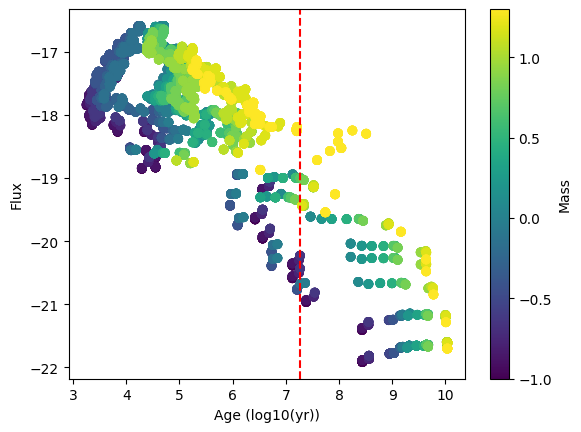

In [33]:
plt.figure()
plt.scatter(np.log10(ages),np.log10(photo_filter),c=np.log10(combinations[:,0]))
plt.axvline(np.log10(age_system * 1e6), color='r', linestyle='--')
plt.xlabel('Age (log10(yr))')
plt.ylabel('Flux')
plt.colorbar(label='Mass')
plt.show()

func = LinearNDInterpolator(list(zip(np.log10(photo_filter),np.log10(ages))),combinations[:,0],rescale=True)

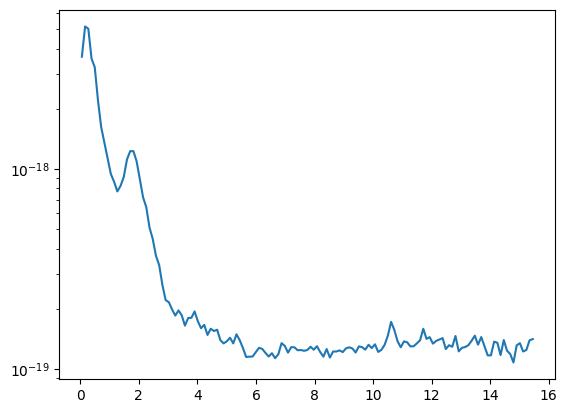

In [34]:
df = pd.read_csv('../data/detection_limits/detection_limit_HD181327.dat',sep=' ',header=None,names=['Seperation','flux'])
df['flux'] = Jy_to_flux(df['flux']*1e-6,11.4)*8.5
plt.plot(df['Seperation'],df['flux'])
plt.yscale('log')

[        nan         nan         nan         nan         nan         nan
 18.18708792 18.06981151 17.78843388 18.46598255 18.80611434 19.2404243
 18.99591718 18.59847037 17.82028356 17.71340269 17.71099059 17.89933705
 18.69791114 19.50352747 19.94509837 19.95262315 19.49316955 17.46534486
 16.33538294 13.9447331  12.1158371  11.86185761 10.98857974 10.2490391
 10.86365437 10.28230151  9.03786816  9.95625625  9.97907062 10.74781676
  9.56061698  8.72151354  9.12476312  7.90700476  8.65708066  8.38205286
  8.54009399  7.27753787  6.88700115  7.14399216  7.56835254  6.88700115
  7.98998564  7.27753787  6.50538685  5.76434927  5.78870788  5.80085613
  6.15602408  6.51637724  6.42797742  6.09804125  5.80085613  6.0747158
  5.66607633  5.99247214  6.91756443  6.67923723  6.12129084  6.57107715
  6.5601706   6.315918    6.33847084  6.27059776  6.33847084  6.60369734
  6.36095276  6.64696067  6.16756443  5.78870788  6.41685019  5.71538166
  6.21354044  6.21354044  6.30461484  6.16756443  6.47

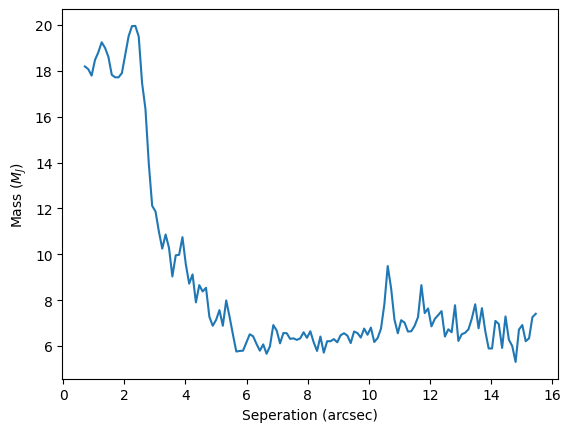

In [36]:
mass_limits = func(np.log10(df['flux']),np.log10(age_system*1e6))
print(mass_limits)
plt.figure()
plt.plot(df['Seperation'],mass_limits,'-')
plt.xlabel('Seperation (arcsec)')
plt.ylabel(r'Mass $(M_J)$')
plt.show()
